## Goal: Correlate the number of variants from known (v47) SS-proximal regions (+-1.6kb) with the number of added ICs uniq to personalized GRCh38s or number of novel ICs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

1097448
1422991


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


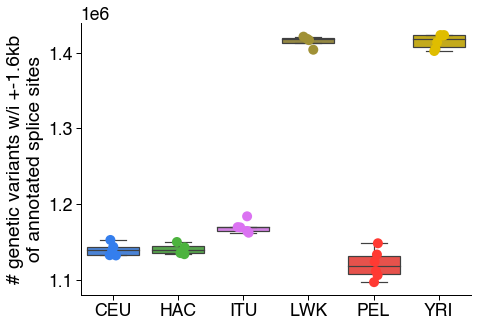

In [20]:
# load the nvars
var_df = pd.read_csv(proc_cfg(config['1000g']['n_ss_intersect_summary'], od), sep='\t')
var_df['cell_line_id'] = var_df.cell_line_id.str.rsplit('/', expand=True, n=1)[1]

# range
print(var_df.n_vars.min())
print(var_df.n_vars.max())

var_df = var_df.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

# plot n_vars by pop
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=var_df.population.unique().tolist())
ax = sns.boxplot(var_df,
            x='population',
            y='n_vars',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='n_vars', data=var_df, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [5]:
# make a df to hold the different corr. values
corr_df = pd.DataFrame()

In [6]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
temp = df.loc[df.structural_category!='full-splice_match']

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')


# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')
temp.head()

,ic_id,cell_line_id,hap1,hap2,hg38,n_novel_ic,n_non_hg38_novel_ic
10,GL000194.1_-_114985-112838-112791-55676-55445-...,NA19390,True,False,False,19718,678
29,GL000194.1_-_114985-112850-112791-55676-55445-...,HG03729,False,True,False,20681,800
30,GL000194.1_-_114985-112850-112791-55676-55445-...,HG04217,False,True,False,20687,729
70,GL000194.1_-_114985-112850-112791-55676-55445-...,HG04217,False,True,False,20687,729
550,KI270726.1_+_26126-26229,HG02261,True,False,False,26337,964


## Personalized-GRCh38-specific novel

0.20903884942952836
0.2676004488892886

0.25233645484530876
0.178539652464818


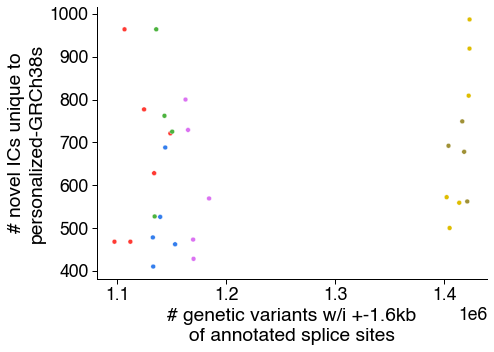

In [7]:
# add number of non-hg38 discovered novel SJs
var_df = var_df.merge(temp[['cell_line_id', 'n_non_hg38_novel_ic']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
init_plot_settings(aspect='rectangle')
ax = sns.scatterplot(var_df, y='n_non_hg38_novel_ic', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# novel ICs unique to\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_non_hg38_novel_ic.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'nov_ic_pers_uniq', 'uniq', 'novel'],
                          [rho, rho_p, 'spearman', 'nov_ic_pers_uniq', 'uniq', 'novel']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

## Personalized-GRCh38 novel

-0.10822070469840231
0.5691942897553426

0.033592880978865404
0.8601156210111618


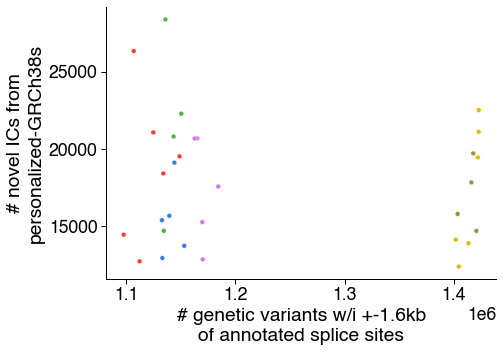

In [8]:
# add number of non-hg38 discovered novel ICs
var_df = var_df.merge(temp[['cell_line_id', 'n_novel_ic']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
init_plot_settings(aspect='rectangle')
ax = sns.scatterplot(var_df, y='n_novel_ic', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# novel ICs from\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_novel_ic.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'nov_ic', 'all', 'novel'],
                          [rho, rho_p, 'spearman', 'nov_ic', 'all', 'novel']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

## Personalized-GRCh38 novel NIC and NNC only (novel splicing) uniq

In [9]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only NNC / NIC and count per cell line
# temp = df.loc[df.structural_category!='full-splice_match']
temp = df.loc[df.structural_category.isin(['novel_not_in_catalog', 'novel_in_catalog'])]

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_nic_nnc_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')


# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_nic_nnc_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')
temp.head()

,ic_id,cell_line_id,hap1,hap2,hg38,n_nic_nnc_ic,n_non_hg38_nic_nnc_ic
10,GL000194.1_-_114985-112838-112791-55676-55445-...,NA19390,True,False,False,17215,567
29,GL000194.1_-_114985-112850-112791-55676-55445-...,HG03729,False,True,False,18336,695
30,GL000194.1_-_114985-112850-112791-55676-55445-...,HG04217,False,True,False,18320,634
70,GL000194.1_-_114985-112850-112791-55676-55445-...,HG04217,False,True,False,18320,634
320,chr10_+_100987610-100989643-100989884-10099043...,NA19307,True,True,False,13740,588


0.1952756310713283
0.30108048848674335

0.22091212458286985
0.24074183075197952


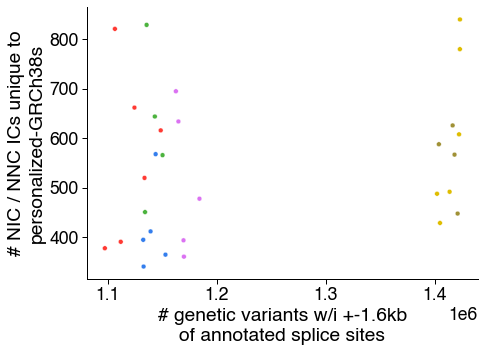

In [10]:
# add number of non-hg38 discovered novel ICs
var_df = var_df.merge(temp[['cell_line_id', 'n_non_hg38_nic_nnc_ic']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
init_plot_settings(aspect='rectangle')
ax = sns.scatterplot(var_df, y='n_non_hg38_nic_nnc_ic', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# NIC / NNC ICs unique to\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_non_hg38_nic_nnc_ic.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_non_hg38_nic_nnc_ic', 'uniq', 'nic_nnc'],
                          [rho, rho_p, 'spearman', 'n_non_hg38_nic_nnc_ic', 'uniq', 'nic_nnc']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

## All nic + nnc

-0.11053735696714573
0.5609044028887731

0.02736373748609566
0.8858673112521354


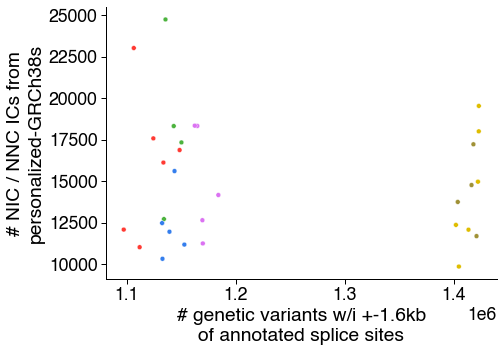

In [11]:
# add number of non-hg38 discovered novel ICs
var_df = var_df.merge(temp[['cell_line_id', 'n_nic_nnc_ic']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
init_plot_settings(aspect='rectangle')
ax = sns.scatterplot(var_df, y='n_nic_nnc_ic', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# NIC / NNC ICs from\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_nic_nnc_ic.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_nic_nnc_ic', 'all', 'nic_nnc'],
                          [rho, rho_p, 'spearman', 'n_nic_nnc_ic', 'all', 'nic_nnc']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

## All ICs from personalized grch38 (both known and novel allowed)

In [12]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# # 1.5 only NNC / NIC and count per cell line
# # temp = df.loc[df.structural_category!='full-splice_match']
# temp = df.loc[df.structural_category.isin(['novel_not_in_catalog', 'novel_in_catalog'])]

# get only the detection from mapping
temp = df[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')


# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')
temp.head()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,ic_id,cell_line_id,hap1,hap2,hg38,n_ic,n_non_hg38_ic
39,GL000194.1_-_114985-112838-112791-55676-55445-...,NA19390,True,False,False,53513,795
78,GL000194.1_-_114985-112850-112791-55676-55445-...,HG03729,False,True,False,53270,890
79,GL000194.1_-_114985-112850-112791-55676-55445-...,HG04217,False,True,False,54097,811
132,GL000194.1_-_114985-112850-112791-55676-55445-...,HG04217,False,True,False,54097,811
2304,GL000218.1_-_97367-95232-95173-40872,HG04217,True,False,False,54097,811


-0.10807946232783545
0.5697014928979073

0.05139043381535039
0.7873951348360015


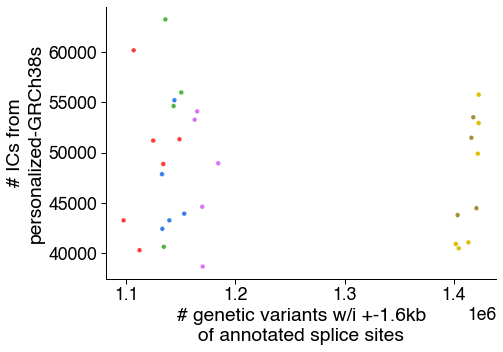

In [13]:
# add number of non-hg38 discovered novel ICs
var_df = var_df.merge(temp[['cell_line_id', 'n_ic']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
init_plot_settings(aspect='rectangle')
ax = sns.scatterplot(var_df, y='n_ic', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# ICs from\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_ic.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_ic', 'all', 'all'],
                          [rho, rho_p, 'spearman', 'n_ic', 'all', 'all']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

## Personalized-GRCh38-specific ICs (known+novel)

0.28100098930096584
0.13252911271833304

0.2968072106473988
0.11122043817616357


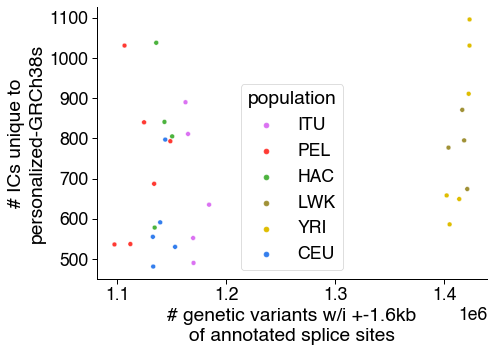

In [25]:
# add number of non-hg38 discovered novel ICs
var_df = var_df.merge(temp[['cell_line_id', 'n_non_hg38_ic']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
init_plot_settings(aspect='rectangle')
ax = sns.scatterplot(var_df, y='n_non_hg38_ic', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# ICs unique to\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend([],[], frameon=False)

x = var_df.n_non_hg38_ic.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_non_hg38_ic', 'uniq', 'all'],
                          [rho, rho_p, 'spearman', 'n_non_hg38_ic', 'uniq', 'all']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

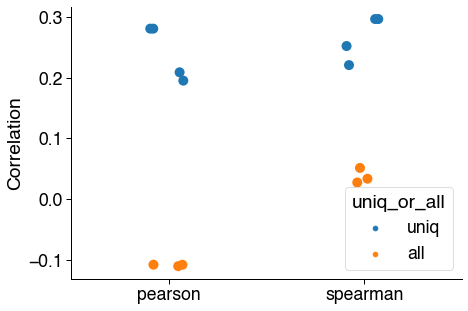

In [29]:
init_plot_settings(aspect='rectangle')

# ax = sns.boxplot(corr_df,
#             x='corr_type',
#             y='corr',
#             hue='uniq_or_all',
#             saturation=0.75,
#             showfliers=False)
ax =sns.stripplot(x='corr_type', y='corr', data=corr_df, jitter=True,
              hue='uniq_or_all',
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='Correlation')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

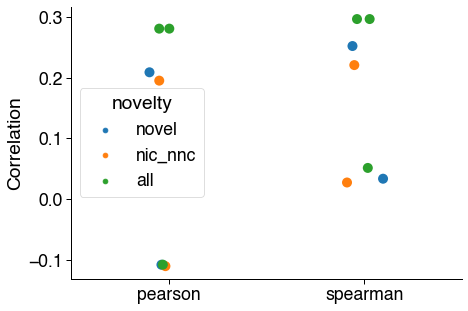

In [28]:
init_plot_settings(aspect='rectangle')

# ax = sns.boxplot(corr_df,
#             x='corr_type',
#             y='corr',
# hue='novelty',
#                  saturation=0.75,
#             showfliers=False)
ax =sns.stripplot(x='corr_type', y='corr', data=corr_df, jitter=True,
              hue='novelty',
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='Correlation')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [23]:
corr_df.sort_values(by='corr', ascending=False)

,corr,pval,corr_type,comparison,uniq_or_all,novelty
1,0.296807,0.111220,spearman,n_non_hg38_ic,uniq,all
0,0.281001,0.132529,pearson,n_non_hg38_ic,uniq,all
1,0.252336,0.178540,spearman,nov_ic_pers_uniq,uniq,novel
1,0.220912,0.240742,spearman,n_non_hg38_nic_nnc_ic,uniq,nic_nnc
0,0.209039,0.267600,pearson,nov_ic_pers_uniq,uniq,novel
0,0.195276,0.301080,pearson,n_non_hg38_nic_nnc_ic,uniq,nic_nnc
1,0.051390,0.787395,spearman,n_ic,all,all
1,0.033593,0.860116,spearman,nov_ic,all,novel
1,0.027364,0.885867,spearman,n_nic_nnc_ic,all,nic_nnc
0,-0.108079,0.569701,pearson,n_ic,all,all
